In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import keras
import keras_nlp

from datetime import datetime


2024-11-24 15:31:37.775964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-24 15:31:37.804174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-24 15:31:37.813867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 15:31:37.836178: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 15:31:38.996743: W tensorflow/compiler/tf2

In [2]:
keras.utils.set_random_seed(69)

In [3]:
df = pd.read_csv("../data/clean/2024-11-24_15-31-02.csv")
df.head()

,Task,Category
0,Finish Quarterly Report,urgent important
1,Schedule Meeting with Client X,urgent important
2,Respond to Urgent Email,urgent not-important
3,Clean Desk,not-urgent not-important
4,Learn New Programming Language,not-urgent important


# Create Dataset

In [4]:
sentences = df["Task"].to_numpy()
labels = df["Category"].to_numpy()

dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))
dataset = dataset.shuffle(len(dataset))

print(sentences[:10])
print()
print(labels[:10])

I0000 00:00:1732437101.166538   10186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732437101.226981   10186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732437101.227064   10186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732437101.232989   10186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732437101.233145   10186 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

['Finish Quarterly Report' 'Schedule Meeting with Client X'
 'Respond to Urgent Email' 'Clean Desk' 'Learn New Programming Language'
 'Pay Monthly Bills' 'Exercise Regularly' 'Read Book on Leadership'
 'Attend Networking Event' 'Plan Vacation']

['urgent important' 'urgent important' 'urgent not-important'
 'not-urgent not-important' 'not-urgent important' 'urgent not-important'
 'not-urgent important' 'not-urgent important' 'not-urgent important'
 'not-urgent important']


# Hyperparameters

In [5]:
EMBEDDING_DIM = 100
MAX_LENGTH = 64
TRAINING_SPLIT = 0.9
NUM_BATCHES = 128

# Split Dataset

In [6]:
train_size = int(len(dataset) * TRAINING_SPLIT)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

train_ds = train_ds.batch(NUM_BATCHES)
val_ds = val_ds.batch(NUM_BATCHES)

print(f"There are {len(train_ds)} batches for a total of {NUM_BATCHES*len(train_ds)} elements for training.")
print(f"There are {len(val_ds)} batches for a total of {NUM_BATCHES*len(val_ds)} elements for validation.")

There are 9 batches for a total of 1152 elements for training.
There are 1 batches for a total of 128 elements for validation.


# Vectorize Dataset

In [7]:
train_sentences = train_ds.map(lambda x, _: x)  
train_labels = train_ds.map(lambda _, y: y)

In [8]:
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
    train_sentences,
    lowercase=True,
    vocabulary_size=8000,
    reserved_tokens=["[PAD]", "[UNK]"],
)

tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    lowercase=True,
    sequence_length=MAX_LENGTH
)

vocab_size = tokenizer.vocabulary_size()
print(f"Vocabulary size = {vocab_size}")

2024-11-24 15:31:44.403555: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Vocabulary size = 228


In [9]:
label_lookup = keras.layers.StringLookup(num_oov_indices=0)
label_lookup.adapt(train_labels)

print(f"Label size = {label_lookup.vocabulary_size()}")

Label size = 4


2024-11-24 15:31:45.564681: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
for x, y in val_ds.take(1):
    sample_string = x[1]

tokenized_string = tokenizer.tokenize(sample_string)
print(f"Tokenized string is {tokenized_string}")

original_string = tokenizer.detokenize(tokenized_string)
print(f"The original string: {original_string}")

Tokenized string is [  9 167  52  47 162  57   9  74 105 105   9 167  61  61 224  59 137   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]
The original string: coordinate crisis communication [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [11]:
train_ds_vec = train_ds.map(lambda x, y: (tokenizer(x), label_lookup(y)))
val_ds_vec = val_ds.map(lambda x, y: (tokenizer(x), label_lookup(y)))

for features, labels in train_ds_vec.take(1):
    print("Features:", features.numpy())
    print("Labels:", labels.numpy())

Features: [[ 65 207  25 ...   0   0   0]
 [ 71   7 169 ...   0   0   0]
 [ 24  37 225 ...   0   0   0]
 ...
 [ 62  19 109 ...   0   0   0]
 [ 45  46 173 ...   0   0   0]
 [ 41  34  12 ...   0   0   0]]
Labels: [1 2 1 2 0 0 0 3 0 3 0 3 1 1 1 0 0 0 0 0 2 2 1 1 0 2 1 0 0 2 1 0 1 0 1 2 1
 0 1 1 2 1 1 0 2 1 1 2 2 3 3 2 3 2 2 1 0 1 0 1 1 0 0 0 1 1 2 0 2 0 2 2 0 1
 0 1 0 1 1 1 0 1 0 3 0 3 1 1 1 1 1 2 1 1 2 3 0 0 1 0 1 3 0 1 2 0 0 0 1 3 3
 0 3 0 1 2 1 0 1 2 0 0 1 0 3 2 1 1]


2024-11-24 15:31:46.718502: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Train

In [12]:
model = keras.Sequential([
    keras.Input(shape=(MAX_LENGTH,)),
    keras.layers.Embedding(vocab_size, EMBEDDING_DIM),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(6, "relu"),
    keras.layers.Dense(4, "softmax"),
])

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 64, 100)        │        22,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,266 (223.70 KB)

 Trainable params: 57,266 (223.70 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit(train_ds_vec, epochs=100, validation_data=val_ds_vec)

Epoch 1/100


2024-11-24 15:31:51.528023: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.3459 - loss: 1.3679 - val_accuracy: 0.3968 - val_loss: 1.3166
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3604 - loss: 1.3026 - val_accuracy: 0.4048 - val_loss: 1.2598
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.4001 - loss: 1.3057 - val_accuracy: 0.5556 - val_loss: 1.2444
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.4426 - loss: 1.2731 - val_accuracy: 0.5476 - val_loss: 1.2212
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5206 - loss: 1.1870 - val_accuracy: 0.5873 - val_loss: 1.0946
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5628 - loss: 1.1324 - val_accuracy: 0.6111 - val_loss: 1.0240
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5615 - loss: 1.0527 - val_accuracy: 0.6587 - val_loss: 0.9157
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5968 - loss: 0.9729 - val_accuracy: 0.5794 - val_loss: 0.9255
Epo

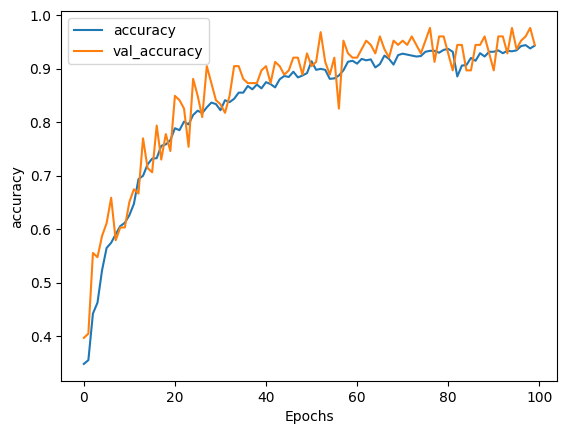

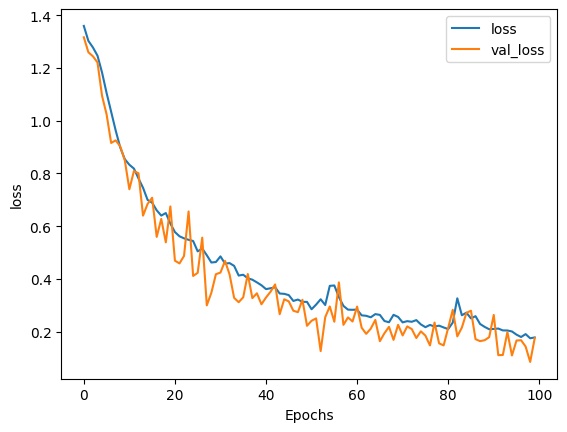

In [14]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Test

In [15]:
task = "Prepare an infrastructure for data migration to cloud which will help the developer team to update the company’s app due in 3 days"
print(f"Input: {task}")

task_vec = tokenizer(task)
print(f"Vectorized input: {tokenizer.detokenize(task_vec)}")
print(f"\t{[x for x in task_vec.numpy()]}\n")
task_vec = np.reshape(task_vec, (1, len(task_vec)))

prediction = model.predict(task_vec)[0]
print(f"Prediction vector: {prediction}")

label_vocab = label_lookup.get_vocabulary()
for label, probability in zip(label_vocab, prediction):
    percentage = probability * 100
    print(f"\t{label}: {percentage:.5f}%")

best = label_vocab[np.argmax(prediction)]
print(f"Prediction: {best}")

Input: Prepare an infrastructure for data migration to cloud which will help the developer team to update the company’s app due in 3 days
Vectorized input: prepare an infrastructure for data migration to cloud which will help the developer team to update the company [UNK] s app due in [UNK] d
	[53, 7, 59, 15, 59, 161, 74, 147, 74, 224, 97, 198, 36, 10, 109, 38, 109, 19, 221, 220, 74, 50, 55, 9, 100, 167, 224, 47, 29, 80, 129, 80, 29, 221, 100, 100, 14, 37, 100, 89, 26, 80, 37, 108, 76, 46, 55, 35, 26, 80, 37, 156, 1, 25, 7, 89, 89, 10, 224, 37, 15, 59, 1, 10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
Prediction vector: [7.2049350e-01 3.3410393e-05 2.7945092e-01 2.2161617e-05]
	not-urgent important: 72.04935%
	not-urgent not-important: 0.00334%
	urgent important: 27.94509%
	urgent not-important: 0.00222%
Prediction: not-urgent important


# Save

In [16]:
packed_model = keras.Sequential([
    tokenizer,
    label_lookup,
    model,
])

packed_model.built = True
now = datetime.now().strftime(r"%Y-%m-%d_%H-%M-%S")
packed_model.save(f"../model/{now}.keras")